This notebook is to implement the algorithm developed in https://www.nature.com/articles/s41598-020-60321-x where they outline a method to simulate non-unitary channels (here, the AD channel is implemented) using unitary gates courtesy of the Sz.-Nagy dilation theorem.

Here, an AD channel is implemented. The Kraus operators for this channel are non-unitary. Using the dilation theorem, its corresponding unitary gates are found and the time-evolution of an initial density matrix is calculated. Details of this are worked out in my iPad and in the paper. 

To convert this numerical algorithm to a quantum algorithm that can be implemented on a quantum circuit, we use the theorem that says a unitary gate can be decomposed to a sequence of two-level unitary gates. This is how the dilations are mapped to unitary gates that can be implemented on a quantum circuit. Numerical calculation has been done on iPad and results plotted in the paper. 

The supplementary information (SI) part of the paper gives the rest of the circuits ready-made. In this notebook, I'm implementing those circuits to reproduce their results.

My initial state is supposed to be 

$\begin{equation}\rho = \frac{1}{4}\begin{bmatrix} 1 & 1 \\ 1 & 3 \end{bmatrix}\end{equation}$ with the composition $\begin{equation}\rho = \frac{1}{2}(|0\rangle\langle 0| + |+\rangle\langle+|)\end{equation}$.

The operator-sum representation of the time-evolved density matrix is given as,

$\begin{equation}
    \rho(t) = M_0 \rho M_0^\dag + M_1 \rho M_1^\dag
\end{equation}$

where 

$\begin{equation}
    M_0 = \begin{bmatrix} 1 & 0 \\ 0 & \sqrt{e^{-\gamma t}}\end{bmatrix} 
\end{equation}$
$\begin{equation}
    M_1 = \begin{bmatrix} 0 & \sqrt{1-e^{-\gamma t}} \\ 0 & 0 \end{bmatrix}
\end{equation}$

The 1-dilation is defined as $U_A = \begin{bmatrix} A & D_{A^\dag} \\ D_A & -A^\dag \end{bmatrix}$ with the defect operator of $A$ defined as $D_A = \sqrt{1-A^\dag A}$.

The decomposition of $U_{M_0}v_1$ and others into 1-qubit and 2-qubit unitary gates can be performed and displayed in the form of a quantum circuit. The paper gives these circuits and I try to implement it here.

In [1]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

Numerical simulation of $U_{M_k}v_i$ from $t = 0$ to $t = 1000$ ps with $\Delta t = 10$ ps, $\gamma=1.52 \text{ x } 10^9 s^{-1}$ as the damping rate. This means I apply the $U_{M_k}$ gate, which is a function of time, but time replaced with $\Delta t$ and apply it $(t_f - t_i)/\Delta t$ times.

n_steps = 1000
[[0.25 0.25 0.   0.  ]
 [0.25 0.75 0.   0.  ]
 [0.   0.   0.   0.  ]
 [0.   0.   0.   0.  ]]


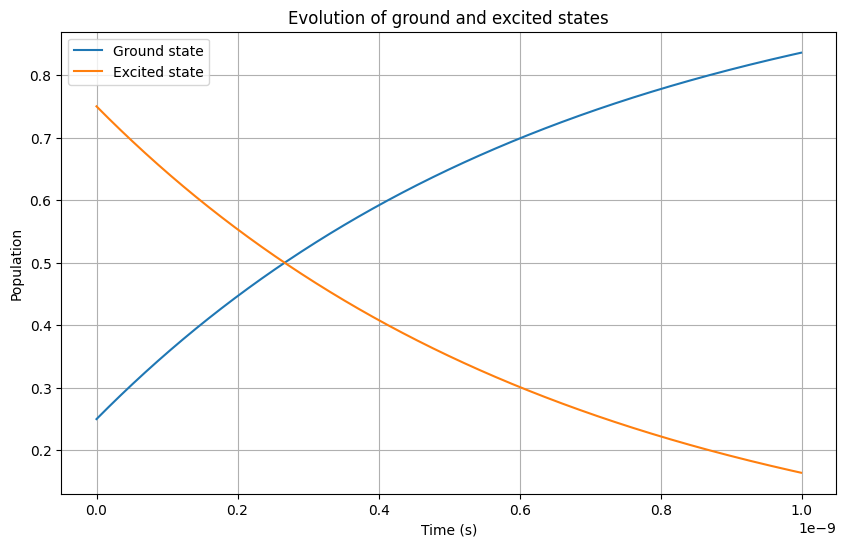

In [ ]:
# Pertinent variables

gamma = 1.52*10**9
total_time = 1000*10**(-12)
delta_t = 1*10**(-12)
n_steps = int(total_time/delta_t)
print(f"n_steps = {n_steps}")

def k_0(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=1
        k[0,1]=0
        k[1,0]=0
        k[1,1]= np.sqrt(np.exp(-gamma*x))
        return k
def k_1(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=0
        k[0,1]=np.sqrt(1-np.exp(-gamma*x))
        k[1,0]=0
        k[1,1]=0
        return k


def calc_UM(multiplicative_factor):

    M_0 = np.array([[1, 0], [0, np.exp(-gamma * multiplicative_factor*delta_t)]])
    M_1 = np.array([[0, np.sqrt(1 - np.exp(-gamma * multiplicative_factor*delta_t))], [0, 0]])

    M_0_dag = M_0.conj().T
    M_1_dag = M_1.conj().T

    D_M_0 = np.array([[0, 0], [0, np.sqrt(1 - np.exp(-gamma * multiplicative_factor*delta_t))]])
    D_M_1 = np.array([[1, 0], [0, np.exp(-gamma * multiplicative_factor*delta_t)]])

    D_Mdag_0 = np.array([[0, 0], [0, np.sqrt(1 - np.exp(-gamma * multiplicative_factor*delta_t))]])
    D_Mdag_1 = np.array([[1, 0], [0, np.exp(-gamma * multiplicative_factor*delta_t)]])

    U_M_0 = np.block([[M_0, D_Mdag_0], [D_M_0, -M_0_dag]])
    U_M_1 = np.block([[M_1, D_Mdag_1], [D_M_1, -M_1_dag]])

    return U_M_0, U_M_1

def UM_py(multiplicative_factor):
   
    M_0 = k_0(multiplicative_factor*delta_t)
    M_1 = k_1(multiplicative_factor*delta_t)

    M_0_dag = M_0.conj().T
    M_1_dag = M_1.conj().T

    iden = np.eye(2,2)
    D_M_0 = sp.sqrtm(iden - np.dot(M_0_dag,M_0)) 
    D_M_1 = sp.sqrtm(iden - np.dot(M_1_dag,M_1)) 

    D_Mdag_0 = sp.sqrtm(iden - np.dot(M_0,M_0_dag)) 
    D_Mdag_1 = sp.sqrtm(iden - np.dot(M_1,M_1_dag))

    U_M_0 = np.block([[M_0, D_Mdag_0], [D_M_0, -M_0_dag]])
    U_M_1 = np.block([[M_1, D_Mdag_1], [D_M_1, -M_1_dag]])

    return U_M_0, U_M_1

# Define vectors v_1 and v_2
v_1 = np.array([0, 1, 0, 0])
v_2 = (1 / np.sqrt(2)) * np.array([1, 1, 0, 0])
p1 = 0.5
p2 = 0.5

# Initialize density matrices
rho_0 = np.outer(v_1, v_1)
rho_1 = np.outer(v_2, v_2)

# Initialize the final density matrix
mixed_rho = p1 * rho_0 + p2 * rho_1
print(mixed_rho)
mixed_rho_norm = sp.norm(mixed_rho)
mixed_rho_initial = mixed_rho

elements_00 = []
elements_11 = []

# Time evolution
for step in range(n_steps):

    U_M_0, U_M_1 = UM_py(step)

    mixed_rho = (
        U_M_0 @ mixed_rho @ U_M_0.T + U_M_1 @ mixed_rho @ U_M_1.T
    )
    addn_norm = sp.norm(mixed_rho)
    elements_00.append((mixed_rho[0,0])*(1))
    elements_11.append((mixed_rho[1,1])*(1))

    mixed_rho = mixed_rho_initial

time_steps = [step * delta_t for step in range(n_steps)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(time_steps, elements_00, label="Ground state")
plt.plot(time_steps, elements_11, label="Excited state")
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.title("Evolution of ground and excited states")
plt.legend()
plt.grid()
plt.show()


#   Lesson here: After every timestep application of U, I had to retain only the upper left block of the matrix before I applied U again. This looks akin to projection back to H after every application of H.

Trying out Sabre's and collaborator's code

In [9]:
import numpy as np
import scipy.linalg as sp
import matplotlib.pyplot as plt
import qiskit
from qiskit import *
from qiskit_aer import AerSimulator
from qiskit.quantum_info.operators import Operator

In [10]:
#defining the initial density matrix rho
rho = np.zeros((2,2),'complex') 
rho[0,0]=1/4
rho[0,1]=1/4
rho[1,0]=1/4
rho[1,1]=3/4
gamma=1.52e9# gamma is the spontaneous emission rate

iden=np.eye(2)
iden2= np.eye(4)

#flattening or vectorize the density matrix
rho_norm=sp.norm(rho)
rho_flat= rho.flatten()/rho_norm
#defining the Kraus operators
def k_0(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=1
        k[0,1]=0
        k[1,0]=0
        k[1,1]= np.sqrt(np.exp(-gamma*x))
        return k
def k_1(x):    
        k = np.zeros((2,2),'complex')
        k[0,0]=0
        k[0,1]=np.sqrt(1-np.exp(-gamma*x))
        k[1,0]=0
        k[1,1]=0
        return k

In [11]:
#defining the function for dilation
def udil(k):
#first and second stands for the M and N, i.e. Kraus and its complex conjugate   
    first= np.kron(k,iden)
    kc=k.conjugate()  #complex conjugate of k
    second= np.kron(iden,kc)
    fcon = (first.conjugate()).T
    scon = (second.conjugate()).T
    #calculate the defect operators of each Kraus operators
    fdef = sp.sqrtm(iden2-np.dot(fcon,first))
    sdef = sp.sqrtm(iden2 -np.dot(scon,second))
    fcondef = sp.sqrtm(iden2-np.dot(first,fcon))
    scondef = sp.sqrtm(iden2-np.dot(second,scon))
    #2-dilation process 
    Ufirst= np.block([[first, np.zeros((4,4)),fcondef,np.zeros((4,4))],
    [fdef,np.zeros((4,4)),-fcon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])
    
    Usecond=np.block([[second, np.zeros((4,4)),scondef,np.zeros((4,4))],
    [sdef,np.zeros((4,4)),-scon,np.zeros((4,4))],
    [np.zeros((4,4)),np.eye(4),np.zeros((4,4)),np.zeros((4,4))],
    [np.zeros((4,4)),np.zeros((4,4)),np.zeros((4,4)),np.eye(4)]])

    ufre=np.reshape(Ufirst,(1,256))
    usec=np.reshape(Usecond,(1,256))
    #returning the unitaries for both the Kraus operator and its complex conjugate
    return ufre,usec 

In [12]:
#defining lists used to store the results
rho_at_t=np.zeros((1000,2), "complex")
time=np.zeros((1000,1),)
udil01=np.zeros((1000,256),"complex")
udil02=np.zeros((1000,256),"complex")
udil11=np.zeros((1000,256),"complex")
udil12=np.zeros((1000,256),"complex")
# assigning the time-steps
for t in range(0,1000):
    tt=t*10**-12
    k0=k_0(tt)
    k1=k_1(tt)
    udil01[t],udil02[t] = udil(k0)    
    udil11[t],udil12[t] = udil(k1)

shots = 2000
#create dictionaries to store the results. three binary digits due to 8*8 matrix needs three qubits
result = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0} 
result2 = {'0000': 0, '0001': 0, '0010': 0, '0011': 0,'0100': 0, '0101': 0, '0110': 0, '0111': 0, '1000': 0, '1001': 0, '1010': 0, '1011': 0,'1100': 0, '1101': 0, '1110': 0, '1111': 0} 
p_excited = []# create list to store probability for acceptor state
p_ground = []# create list to store probability for donor state

# Below are the loop of the QASM simulation 
aersim=AerSimulator(method='statevector')
for i in range (0,1000):
    #for Kraus operator 1
    U1first=np.reshape(udil01[i],(16,16))
    U1second=np.reshape(udil02[i],(16,16))
    # qiskit quantum circuit generation process
    initial_state = np.concatenate([rho_flat,np.zeros(12)])
    qr = QuantumRegister(4)
    cr = ClassicalRegister(4)
    qc = QuantumCircuit(qr, cr)
    qc.initialize(initial_state, qr)
    # generating self-defined quantum gates with dilated unitaries
    A = Operator(U1first)
    B = Operator(U1second)      # WHYYYYYYYYYY
    U_G_op = A.compose(B)
    qc.unitary(U_G_op, qr)
    qc.measure(qr, cr)
    counts1 = aersim.run(qc,shots=shots).result().get_counts()
    for x in counts1:
        result[x] = counts1[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg1 = np.sqrt(result['0000'] / 2000)*rho_norm
    pe1 =  np.sqrt(result['0011'] / 2000)*rho_norm    
    #for Kraus operator 2
    U2first=np.reshape(udil11[i],(16,16))
    U2second=np.reshape(udil12[i],(16,16))
    initial_state2 = np.concatenate([rho_flat,np.zeros(12)])
    qr2 = QuantumRegister(4)
    cr2 = ClassicalRegister(4)
    qc2 = QuantumCircuit(qr2, cr2)
    qc2.initialize(initial_state, qr2)    
    C = Operator(U2first)
    D = Operator(U2second)      #   WHYYYYYYYYYYYY
    U_G_op2 = C.compose(D)   
    qc2.unitary(U_G_op2, qr2)
    qc2.measure(qr2, cr2)
    counts2 = aersim.run(qc2, shots=shots).result().get_counts()
    for x in counts2:
        result2[x] = counts2[x]
    # multiply the norm factor to retrieve the original data, sqrt because the results is probability not prob density
    pg2 = np.sqrt(result2['0000'] / 2000)*rho_norm
    pe2 =  np.sqrt(result2['0011'] / 2000)*rho_norm    
    pe=pe1+pe2
    pg=pg1+pg2
    p_excited.append(pe)
    p_ground.append(pg)

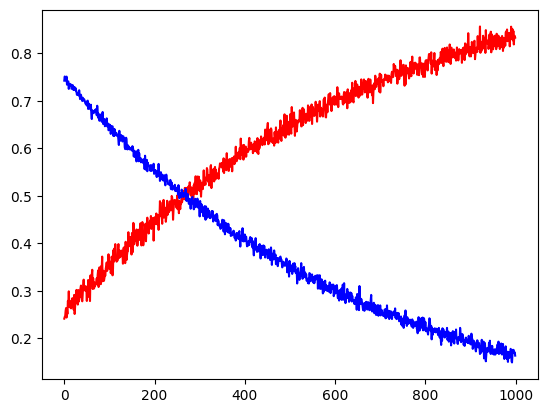

In [13]:
#plotting the QASM simulation results
time_array_QASM = np.arange(0, 1000, 1)

plt.plot(time_array_QASM, p_ground, 'r-', label="Ground state")
plt.plot(time_array_QASM, p_excited, 'b-', label='Excited state')

/home/sameer/anaconda3/envs/quantum_algorithms/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sameer/anaconda3/envs/quantum_algorithms/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


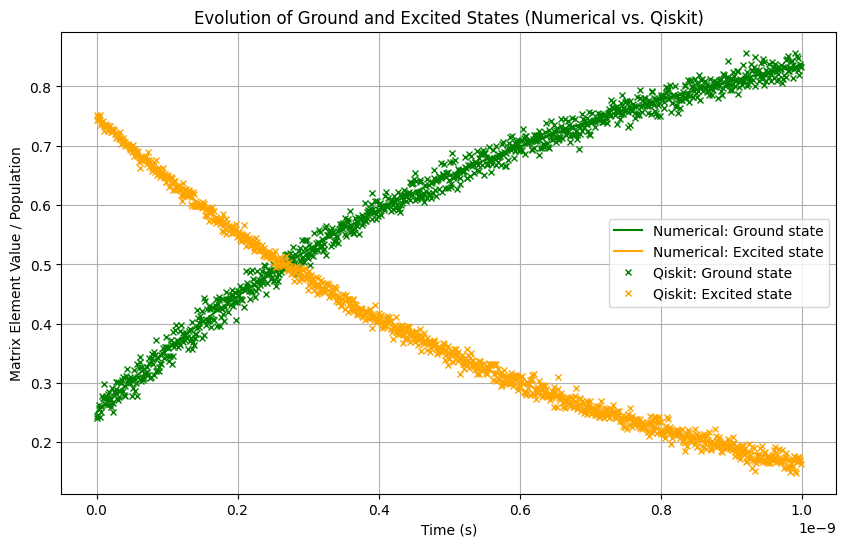

In [14]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot the results from the Kraus operators
plt.plot(time_steps, elements_00, label="Numerical: Ground state", color = "green", markersize=4)
plt.plot(time_steps, elements_11, label="Numerical: Excited state", color = "orange", markersize=4)

# Plot the results from Qiskit simulations
plt.plot(time_steps, p_ground, label="Qiskit: Ground state", marker = "x", linestyle="None", color = "green", markersize=4)
plt.plot(time_steps, p_excited, label="Qiskit: Excited state", marker = "x", linestyle="None", color = "orange", markersize=4)

# Configure the plot
plt.xlabel("Time (s)")
plt.ylabel("Matrix Element Value / Population")
plt.title("Evolution of Ground and Excited States (Numerical vs. Qiskit)")
plt.legend()
plt.grid()
plt.show()